In [1]:
# 导入必要的库：
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # 'Heiti TC' 是 Mac 系统中的黑体， Windows系统上将字体设置为“SimHei”。
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from src.data_preprocessing import load_data, clean_data
from src.feature_engineering import perform_feature_engineering


In [2]:
# 加载和准备数据：
# 示例数据文件路径
train_data_path = "../data/raw/order_train0.csv"

# 数据加载和清洗
train_data = load_data(train_data_path)

# 清洗
if train_data is not None:
    train_data = clean_data(train_data)

# 特征工程
if train_data is not None:
    train_data = perform_feature_engineering(train_data, 'order_date')
    


In [3]:
train_data.to_csv("../data/processed/processed_data.csv", index = False)

In [4]:
train_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,item_price,ord_qty,year,month,day,weekday,season,sales_chan_name_offline,sales_chan_name_online,is_holiday,month_phase,is_promo
0,2015-09-02,104,20028,301,405,1005.0,11,2015,9,2,2,Fall,1.0,0.0,False,Early Month,False
1,2015-09-03,102,20354,303,401,1420.0,64,2015,9,3,3,Fall,1.0,0.0,False,Early Month,False
2,2015-09-04,101,20586,306,407,978.0,7,2015,9,4,4,Fall,1.0,0.0,False,Early Month,False
3,2015-09-04,101,20230,306,407,864.0,66,2015,9,4,4,Fall,1.0,0.0,False,Early Month,False
4,2015-09-04,105,21619,306,402,274.0,102,2015,9,4,4,Fall,0.0,1.0,False,Early Month,False


# 价格影响分析
 
- 使用散点图分析产品价格 (item_price) 与需求量 (ord_qty) 之间的关系。
- 考虑使用线性回归模型来定量评估价格对需求的影响。

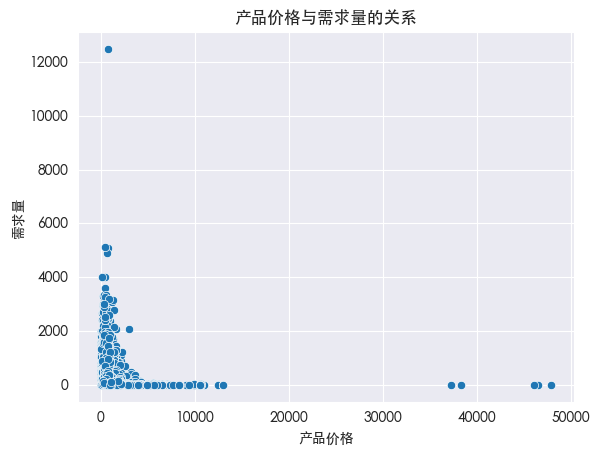

模型评估：
均方误差 (MSE): 34451.556788278525
决定系数 (R^2): 0.020878644170643335


In [5]:
# 绘制散点图
sns.scatterplot(data=train_data, x='item_price', y='ord_qty')
plt.title('产品价格与需求量的关系')
plt.xlabel('产品价格')
plt.ylabel('需求量')
plt.show()

# 线性回归分析
# 准备数据
X = train_data[['item_price']]  # 特征
y = train_data['ord_qty']       # 目标变量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 创建线性回归模型并训练
model = LinearRegression()
model.fit(X_train, y_train)

# 预测和评估
y_pred = model.predict(X_test)
print("模型评估：")
print("均方误差 (MSE):", mean_squared_error(y_test, y_pred))
print("决定系数 (R^2):", r2_score(y_test, y_pred))

# 区域影响分析
- 利用柱状图展示不同销售区域 (sales_region_code) 的产品需求量。
- 对比分析不同区域的需求量差异。

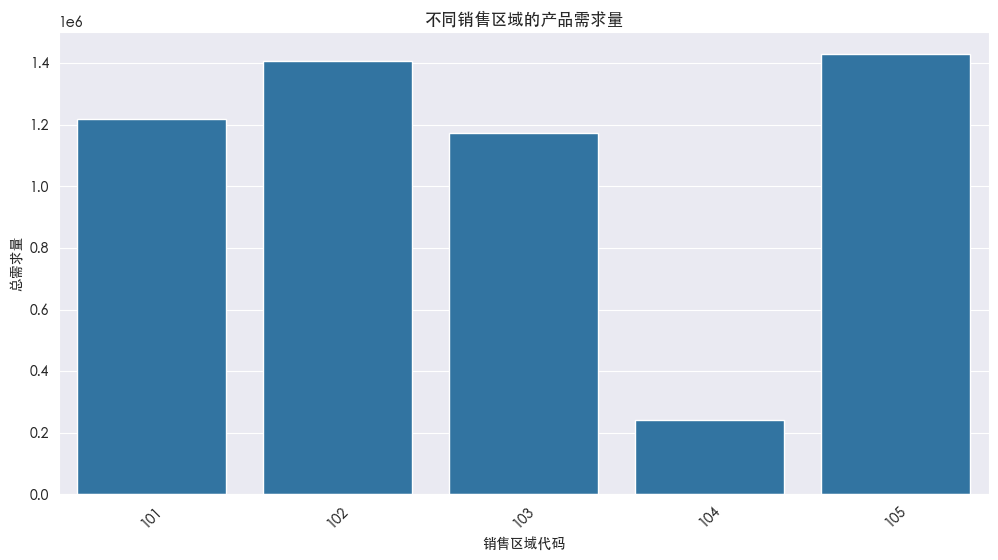

In [6]:
# 绘制柱状图
plt.figure(figsize=(12, 6))
sns.barplot(x='sales_region_code', y='ord_qty', data=train_data, estimator=sum, errorbar=None)
plt.title('不同销售区域的产品需求量')
plt.xlabel('销售区域代码')
plt.ylabel('总需求量')
plt.xticks(rotation=45)
plt.show()

                       sum       mean         std
sales_region_code                                
101                1218082  96.329142  225.595173
102                1405589  85.858469  155.605599
103                1172723  99.518245  206.593491
104                 240645  95.569897  168.307569
105                1428426  86.829129  201.235304


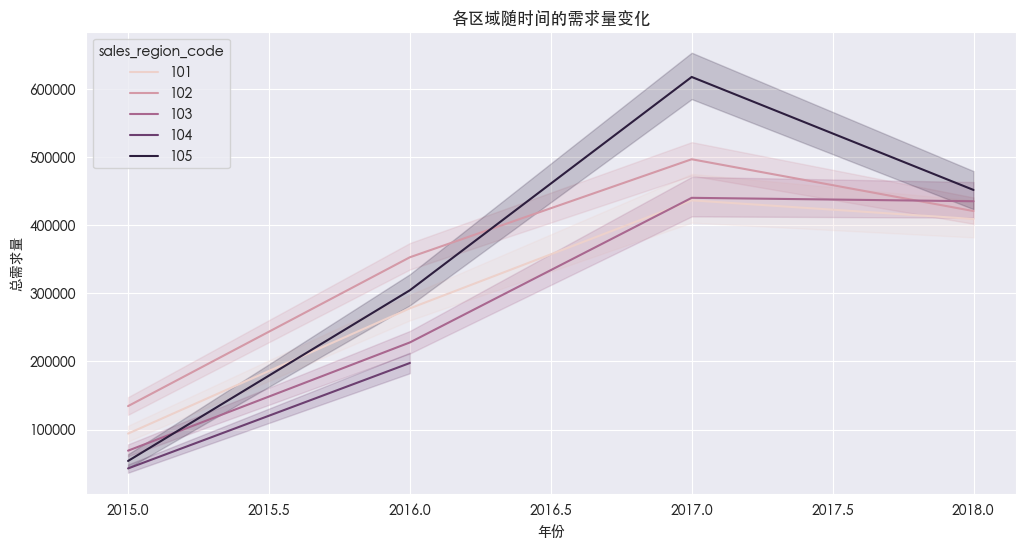

In [7]:
# 分析不同区域需求量的原因和趋势
# 计算每个区域的总需求量和平均需求量
region_demand_summary = train_data.groupby('sales_region_code')['ord_qty'].agg(['sum', 'mean', 'std'])
print(region_demand_summary)

# 可视化不同区域随时间的需求量变化（假设有时间字段）
train_data['year'] = train_data['order_date'].dt.year
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='ord_qty', hue='sales_region_code', data=train_data, estimator=sum)
plt.title('各区域随时间的需求量变化')
plt.xlabel('年份')
plt.ylabel('总需求量')
plt.show()

# 销售方式影响分析
- 对比线上和线下销售 (sales_chan_name) 的需求量。
- 使用柱状图或饼图展示销售方式对需求量的影响。

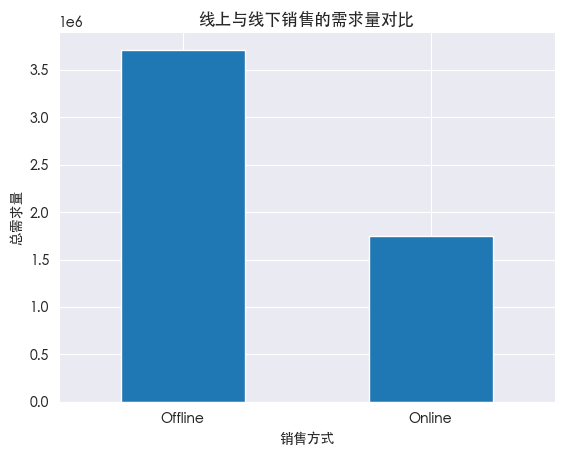

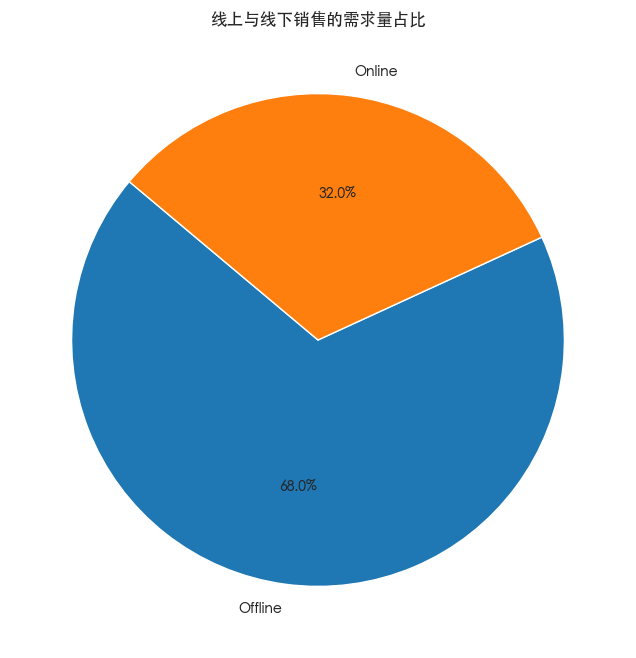

In [8]:
# 计算线上和线下的总需求量
train_data['total_offline'] = train_data['sales_chan_name_offline'] * train_data['ord_qty']
train_data['total_online'] = train_data['sales_chan_name_online'] * train_data['ord_qty']
sales_channel_summary = train_data[['total_offline', 'total_online']].sum()

# 柱状图展示
sales_channel_summary.plot(kind='bar')
plt.title('线上与线下销售的需求量对比')
plt.xlabel('销售方式')
plt.ylabel('总需求量')
plt.xticks(ticks=[0, 1], labels=['Offline', 'Online'], rotation=0)
plt.show()

# 饼图展示
plt.figure(figsize=(8, 8))
plt.pie(sales_channel_summary, labels=['Offline', 'Online'], autopct='%1.1f%%', startangle=140)
plt.title('线上与线下销售的需求量占比')
plt.show()


# 品类比较分析
- 分析不同品类（first_cate_code 和 second_cate_code）的产品需求量。
- 使用堆叠柱状图或分组柱状图展示不同品类的需求量对比。

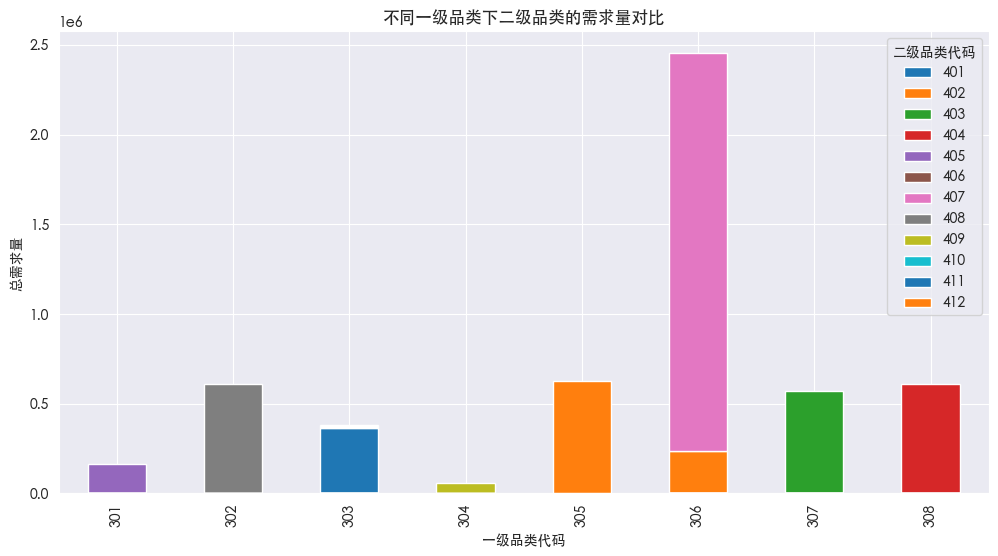

In [9]:
# 准备数据
grouped_data = train_data.groupby(['first_cate_code', 'second_cate_code'])['ord_qty'].sum().unstack()

# 绘制堆叠柱状图
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('不同一级品类下二级品类的需求量对比')
plt.xlabel('一级品类代码')
plt.ylabel('总需求量')
plt.legend(title='二级品类代码')
plt.show()

# 绘制分组柱状图
# grouped_data.plot(kind='bar', figsize=(12, 6))
# plt.title('不同一级品类下二级品类的需求量对比')
# plt.xlabel('一级品类代码')
# plt.ylabel('总需求量')
# plt.legend(title='二级品类代码')
# plt.show()

# 时间段分析
- 分析月初、月中、月末等不同时间段的需求量差异。
- 可以创建一个新特征来表示月份的三个阶段，并使用柱状图展示不同时间段的需求量。

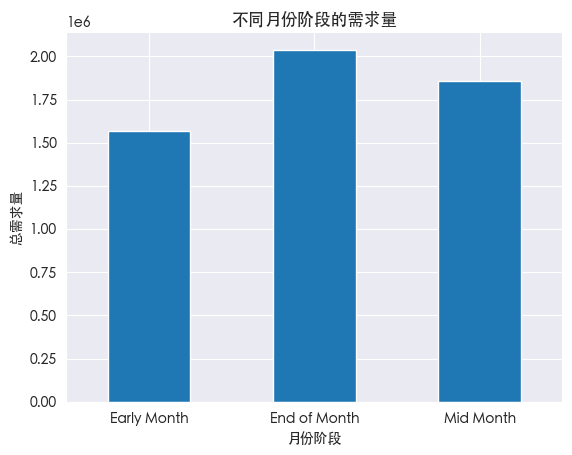

In [10]:
# 汇总不同时间段的需求量
month_phase_demand = train_data.groupby('month_phase')['ord_qty'].sum()

# 绘制柱状图
month_phase_demand.plot(kind='bar')
plt.title('不同月份阶段的需求量')
plt.xlabel('月份阶段')
plt.ylabel('总需求量')
plt.xticks(rotation=0)
plt.show()

# 节假日影响分析
- 如果数据中有节假日的标记，分析节假日与非节假日的需求量差异。
- 使用柱状图或箱线图展示节假日对需求量的影响。

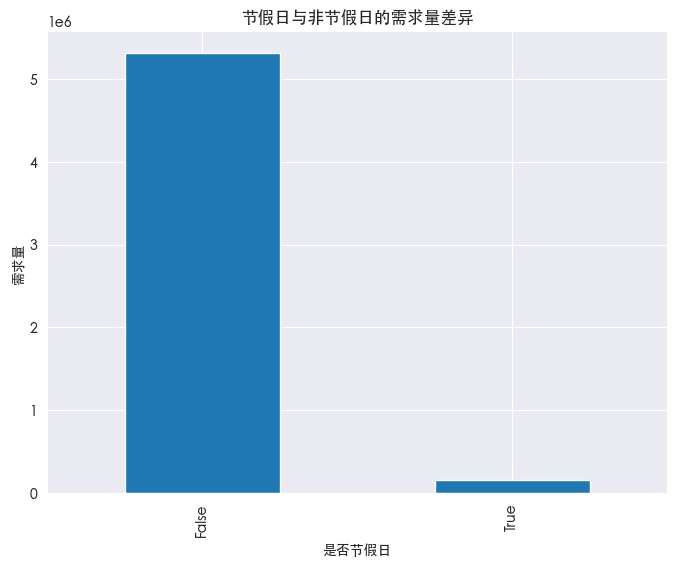

In [11]:
holiday_demand = train_data.groupby('is_holiday')['ord_qty'].sum()
plt.figure(figsize=(8, 6))
holiday_demand.plot(kind='bar')
plt.title('节假日与非节假日的需求量差异')
plt.xlabel('是否节假日')
plt.ylabel('需求量')
plt.show()

# 促销活动影响分析
- 分析促销活动（如618、双十一）期间的需求量与其他时间的对比。
- 需要有相关的促销活动数据标记。

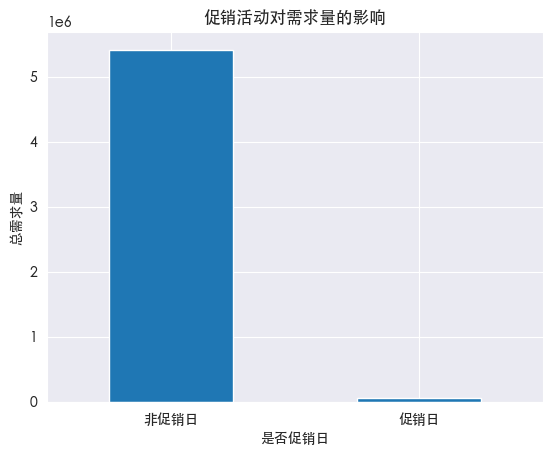

In [12]:
# 分析促销活动对需求量的影响
promo_demand = train_data.groupby('is_promo')['ord_qty'].sum()

# 绘制柱状图
promo_demand.plot(kind='bar')
plt.title('促销活动对需求量的影响')
plt.xlabel('是否促销日')
plt.ylabel('总需求量')
plt.xticks(ticks=[0, 1], labels=['非促销日', '促销日'], rotation=0)
plt.show()

# 季节性影响分析
- 分析不同季节（春、夏、秋、冬）的产品需求量差异。
- 使用柱状图或折线图展示季节与需求量的关系。

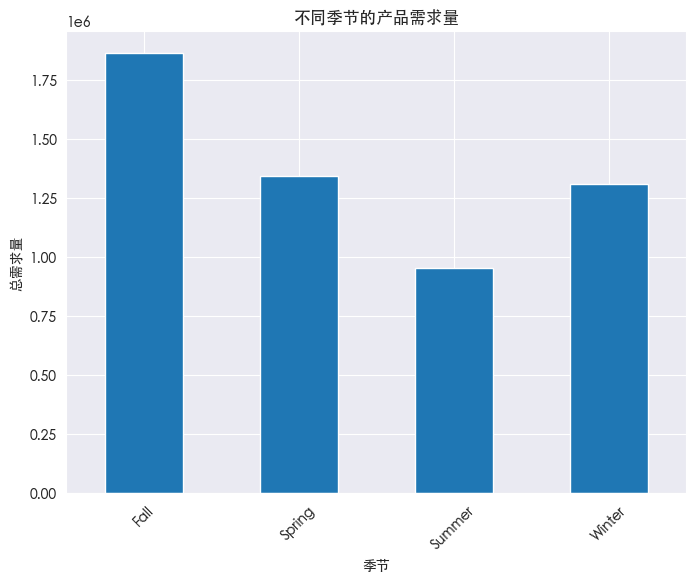

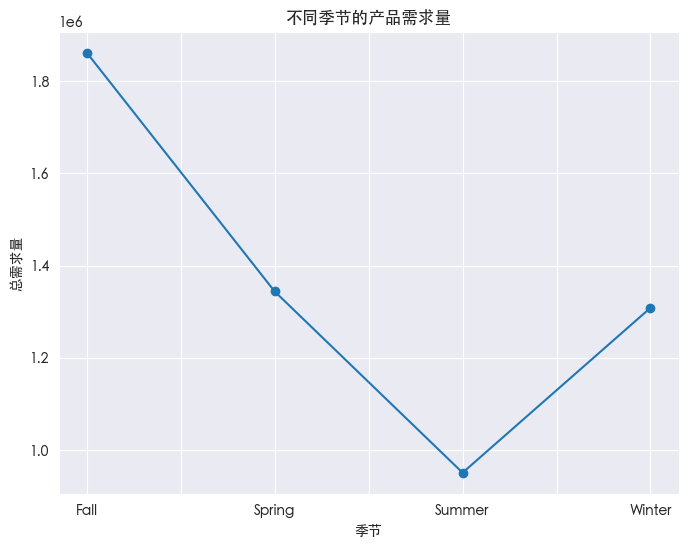

In [13]:
# # 将季节数字转换为季节名称（如果尚未这样做）
# seasons = {1: '春季', 2: '夏季', 3: '秋季', 4: '冬季'}
# train_data['season_name'] = train_data['season'].map(seasons)

# 准备数据
seasonal_demand = train_data.groupby('season')['ord_qty'].sum()
# 
# 绘制柱状图
seasonal_demand.plot(kind='bar', figsize=(8, 6))
plt.title('不同季节的产品需求量')
plt.xlabel('季节')
plt.ylabel('总需求量')
plt.xticks(rotation=45)
plt.show()
# 
# 绘制折线图
seasonal_demand.plot(kind='line', marker='o', figsize=(8, 6))
plt.title('不同季节的产品需求量')
plt.xlabel('季节')
plt.ylabel('总需求量')
plt.show()